In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Sklearn and Imbalanced-learn Libraries
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, VarianceThreshold, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score,
    classification_report
)
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.base import BaseEstimator, TransformerMixin

# Additional Libraries
from sklearn.base import clone
from sklearn.exceptions import NotFittedError
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries with GPU Support
import xgboost as xgb
import lightgbm as lgb

# For SHAP values
import shap

# Statistical Tests
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# For progress monitoring
from tqdm import tqdm
from kneed import KneeLocator


import warnings

# Suppress warnings to reduce clutter
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Necessary imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_X_y, check_array
import pandas as pd
import numpy as np


In [3]:
# File paths
clinical_data_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/Clinical_and_Other_Features_final_comb.xlsx'
features_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/features_extracted_VGG16.pkl.gz'

In [4]:
def load_clinical_data(clinical_data_path):
    """
    Loads and preprocesses clinical data from an Excel file.

    Parameters:
    - clinical_data_path (str): Path to the clinical data Excel file.

    Returns:
    - pd.DataFrame: Preprocessed clinical data.
    """
    print("Loading clinical data...")
    clinical_data = pd.read_excel(clinical_data_path)

    # Rename columns for consistency
    clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
    clinical_data = clinical_data.rename(
        columns={
            'Patient_ID': 'patient_id',
            'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'
        }
    )

    # Convert 'Breast_MRI_001' to '001' in the patient_id column
    clinical_data['patient_id'] = clinical_data['patient_id'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else x
    )

    # Convert response to binary: 1 means pCR, else non-pCR
    clinical_data['response'] = clinical_data['response'].apply(
        lambda x: 1 if x == 1 else 0
    )

    # Preprocess clinical data
    clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

    # Separate numerical and categorical columns
    patient_id_cols = ["patient_id"]
    response_cols = ["response"]
    numerical_cols = ["Date_of_Birth"]  # Consider converting to 'Age at Diagnosis'
    categorical_cols = clinical_data.columns[
        (clinical_data.columns != "Date_of_Birth") &
        (clinical_data.columns != "patient_id") &
        (clinical_data.columns != "response")
    ]

    numerical_df = clinical_data[numerical_cols]
    patient_id_df = clinical_data[patient_id_cols]
    response_df = clinical_data[response_cols]

    # One-hot encode categorical columns
    clinical_data[categorical_cols] = clinical_data[categorical_cols].astype('category')
    categorical_df = pd.get_dummies(clinical_data[categorical_cols], drop_first=True)
    categorical_df = categorical_df.astype(int)

    # Concatenate all dataframes
    encoded_df = pd.concat(
        [patient_id_df, numerical_df, categorical_df, response_df],
        axis=1
    )

    print("Clinical data loaded and processed.")
    return encoded_df

def load_image_features(features_path):
    """
    Loads and processes image features from a compressed pickle file.

    Parameters:
    - features_path (str): Path to the compressed pickle file containing image features.

    Returns:
    - pd.DataFrame: Processed image features.
    """
    print("Loading image features...")
    with gzip.open(features_path, 'rb') as f:
        features_dict = pickle.load(f)

    # Extract patient IDs and features
    features_data = {
        'patient_id': [key.split('-')[0] for key in features_dict.keys()],
        **{
            f'feature_{i}': [features_dict[key][i] for key in features_dict.keys()]
            for i in range(len(next(iter(features_dict.values()))))
        }
    }

    # Create a DataFrame
    features_df = pd.DataFrame(features_data)
    features_df['patient_id'] = features_df['patient_id'].astype(str)
    print("Image features loaded.")
    return features_df


## Data Preprocessing and Merging
def load_and_preprocess_data(clinical_data_path, features_path):
    """
    Loads, preprocesses, and merges clinical and image data.

    Parameters:
    - clinical_data_path (str): Path to the clinical data Excel file.
    - features_path (str): Path to the compressed pickle file containing image features.

    Returns:
    - dict: Dictionary containing dataset variations (Combined, Clinical, Image).
    """
    clinical_data_processed = load_clinical_data(clinical_data_path)
    features_df = load_image_features(features_path)
    clinical_data_processed['patient_id'] = clinical_data_processed['patient_id'].astype(str)
    features_df['patient_id'] = features_df['patient_id'].astype(str)

    # Merge features with clinical data to get the response variable
    print("Merging clinical data with image features...")
    data = features_df.merge(
        clinical_data_processed,
        on='patient_id',
        how='inner'
    )
    print("Data merged successfully.")

    # Prepare three variations of the dataset
    print("Preparing dataset variations...")

    datasets = {}

    # 1. Combined Features
    X_combined = data.drop(columns=['patient_id', 'response'])
    y_combined = data['response'].astype(int)
    

    # 2. Only Clinical Features
    X_clinical = clinical_data_processed.drop(columns=['patient_id', 'response'])
    y_clinical = clinical_data_processed['response'].astype(int)
    # Subset to include only patients present in the merged data
    patient_ids_in_data = clinical_data_processed['patient_id'].isin(data['patient_id'])
    X_clinical = X_clinical.loc[patient_ids_in_data]
    y_clinical = y_clinical.loc[patient_ids_in_data]
    

    # 3. Only Image Features
    image_features = features_df.drop(columns=['patient_id'])
    y_image = data['response'].astype(int)
    X_image = image_features.loc[data.index]
    

    

    # Function to preprocess the data
    def preprocess_data(X):
        """
        Preprocesses the data by removing zero variance features.

        Parameters:
        - X (pd.DataFrame): Feature dataframe.

        Returns:
        - pd.DataFrame: Preprocessed feature dataframe.
        """
        # Remove features with zero variance
        variance_threshold = VarianceThreshold(threshold=0)
        X_var = variance_threshold.fit_transform(X)
        feature_names = X.columns[variance_threshold.get_support(indices=True)]
        X = pd.DataFrame(X_var, columns=feature_names)
        return X

    # Preprocess each dataset variation
    X_combined = preprocess_data(X_combined)
    X_clinical = preprocess_data(X_clinical)
    X_image = preprocess_data(X_image)

    datasets['Combined'] = (X_combined, y_combined)
    datasets['Clinical'] = (X_clinical, y_clinical)
    datasets['Image'] = (X_image, y_image)

    return datasets

In [5]:
# Load and preprocess the data
data_variations = load_and_preprocess_data(clinical_data_path, features_path)

Loading clinical data...
Clinical data loaded and processed.
Loading image features...
Image features loaded.
Merging clinical data with image features...
Data merged successfully.
Preparing dataset variations...


In [6]:
# Initialize dictionaries to store data splits and selected features
data_splits = {}


for dataset_name, (X_full, y_full) in data_variations.items():
    print(f"\nProcessing {dataset_name} Dataset")

    # Step 1: Split Data into Training and Test Sets
    X_train_full, X_test_full, y_train_full, y_test = train_test_split(
        X_full, y_full, test_size=0.5, stratify=y_full, random_state=42
    )
    data_splits[dataset_name] = {
        'X_train_full': X_train_full,
        'X_test_full': X_test_full,
        'y_train_full': y_train_full,
        'y_test': y_test
    }


Processing Combined Dataset

Processing Clinical Dataset

Processing Image Dataset


In [8]:

class MannWhitneyUTestFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer for feature selection using the Mann-Whitney U test
    with Bonferroni correction and optional parallelization.
    """
    def __init__(self, alpha=0.05, bonferroni=True, n_jobs=-1):
        """
        Initialize the selector.

        Parameters:
        - alpha (float): The significance level for the Mann-Whitney U test.
        - bonferroni (bool): Whether to apply Bonferroni correction.
        - n_jobs (int): The number of jobs to run in parallel (default is -1, using all available cores).
        """
        self.alpha = alpha
        self.bonferroni = bonferroni
        self.n_jobs = n_jobs
        self.selected_features_ = None

    def _perform_test(self, col, X, y):
        """
        Helper function to perform Mann-Whitney U test on a single feature.
        """
        group0 = X.loc[y == 0, col]
        group1 = X.loc[y == 1, col]
        try:
            _, p = mannwhitneyu(group0, group1, alternative='two-sided')
        except ValueError:
            p = 1  # Assign high p-value if test fails
        return p

    def fit(self, X, y):
        """
        Fit the selector to the data by performing the Mann-Whitney U test for each feature.
        
        Parameters:
        - X (pd.DataFrame): The input feature matrix.
        - y (pd.Series): The target variable.
        
        Returns:
        - self: The fitted selector.
        """
        # Ensure X is a DataFrame and y is a Series with matching indices
        X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)
        
        # Parallelized Mann-Whitney U tests
        p_values = Parallel(n_jobs=self.n_jobs)(
            delayed(self._perform_test)(col, X, y) for col in X.columns
        )
        
        self.p_values_ = np.array(p_values)
        
        # Apply Bonferroni correction if needed
        if self.bonferroni:
            corrected_alpha = self.alpha / X.shape[1]  # Adjust alpha by number of tests
        else:
            corrected_alpha = self.alpha

        # Select features with p-values below the corrected alpha level
        self.selected_features_ = X.columns[self.p_values_ < corrected_alpha]
        
        return self

    def transform(self, X):
        """
        Transform the data by selecting the features that passed the Mann-Whitney U test.

        Parameters:
        - X (pd.DataFrame): The input feature matrix.

        Returns:
        - pd.DataFrame: The selected feature matrix.
        """
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        return X.loc[:, self.selected_features_]
    
def manual_rfecv(X, y, estimator, cv, scoring='f1', min_features_to_select=5, step=0.1,  early_stopping_rounds=3):
    """
    Manually performs Recursive Feature Elimination with Cross-Validation (RFECV)
    using the specified estimator and cross-validation strategy.
    
    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - estimator: The machine learning estimator to use for feature selection.
    - cv: Cross-validation strategy.
    - scoring (str): Scoring metric (default is 'f1').
    - min_features_to_select (int): Minimum number of features to select.
    - step (float): Proportion of features to remove at each iteration.
    
    Returns:
    - best_features (list): The list of best selected features based on cross-validation score.
    - history (pd.DataFrame): History of number of features and corresponding CV scores.
    """
    
    n_features = X.shape[1]
    step_num = int(max(1, step * n_features))  # Convert the step percentage to an absolute number of features
    
    # History to keep track of scores, feature sets and feature counts
    history = []
    feature_sets = []
    
    # Copy X to avoid modifying the original dataframe
    X_remaining = X.copy()

    # Early stopping tracking
    no_improvement_rounds = 0
    best_score = -np.inf
    
    while X_remaining.shape[1] > min_features_to_select:
        print(f"Evaluating with {X_remaining.shape[1]} features...")
        n_features_remaining = X_remaining.shape[1]
        step_num = int(max(1, step * n_features_remaining)) 
        
        # Perform cross-validation with the current set of features
        scores = cross_val_score(estimator, X_remaining, y, cv=cv, scoring=scoring, n_jobs=-1)
        avg_score = np.mean(scores)
        
        # Append results to the history and store the current feature set
        history.append((X_remaining.shape[1], round(avg_score, 2)))  # Round CV score to 3 decimal places
        feature_sets.append(X_remaining.columns.tolist())
        
        # Early stopping check
        if avg_score > best_score:
            best_score = avg_score
            no_improvement_rounds = 0
        else:
            no_improvement_rounds += 1
        
        if no_improvement_rounds >= early_stopping_rounds:
            print("Early stopping, no significant improvement.")
            break
        
        # Train the model and get feature importances
        estimator.fit(X_remaining, y)
        importances = estimator.feature_importances_
        
        # Create a DataFrame of features and importances
        feature_importances = pd.DataFrame({
            'feature': X_remaining.columns,
            'importance': importances
        })
        
        # Sort features by importance
        feature_importances.sort_values(by='importance', ascending=True, inplace=True)
        
        # Remove the least important features based on step size
        n_to_remove = min(step_num, X_remaining.shape[1] - min_features_to_select)
        features_to_remove = feature_importances.head(n_to_remove)['feature'].tolist()
        
        # Drop the least important features
        X_remaining.drop(columns=features_to_remove, inplace=True)
    
    # Convert history to a DataFrame for easy access
    history_df = pd.DataFrame(history, columns=['n_features', 'cv_score'])
    
    # Identify the best cross-validation score and the corresponding feature sets with the least number of features
    max_score = history_df['cv_score'].max()
    best_idx = history_df[history_df['cv_score'] == max_score]['n_features'].idxmin()  # Minimize the number of features
    
    # The best selected features correspond to the maximum cross-validation score with the least features
    best_features = feature_sets[best_idx]
    
    return best_features, history_df


Starting feature selection for Combined Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Applying SMOTE to balance the classes...
Number of samples after SMOTE: 6806
Class distribution after SMOTE: 
response
0    3403
1    3403
Name: count, dtype: int64

Performing L1-based feature selection...
Number of features after L1-based selection: 100
Resampled data indices are reset after SMOTE.

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 71
Evaluating with 71 features...
Evaluating with 64 features...
Evaluating with 58 features...
Evaluating with 53 features...
Evaluating with 48 features...
Evaluating with 44 features...
Evaluating with 40 features...
Evaluating with 36 features...
Evaluating with 33 features...
Evaluating with 30 features...
Evaluating with 27 features...
Early stopping, no significant improvement.
Best Features: ['feature_82', 

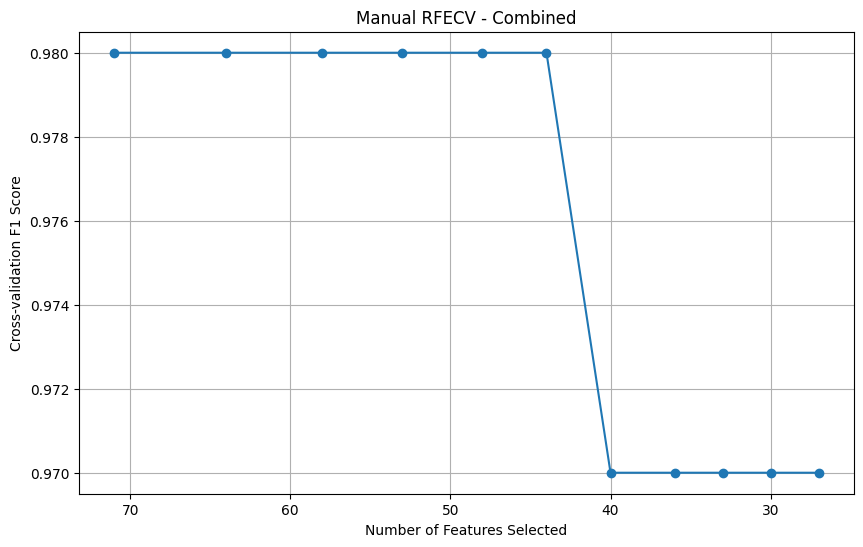


Selecting the final features from the original datasets...

Final datasets for 'Combined' stored with selected features.

Starting feature selection for Clinical Dataset

Skipping feature selection for 'Clinical' dataset. Retaining all original features.

Starting feature selection for Image Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Applying SMOTE to balance the classes...
Number of samples after SMOTE: 6806
Class distribution after SMOTE: 
response
0    3403
1    3403
Name: count, dtype: int64

Performing L1-based feature selection...
Number of features after L1-based selection: 100
Resampled data indices are reset after SMOTE.

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 62
Evaluating with 62 features...
Evaluating with 56 features...
Evaluating with 51 features...
Evaluating with 46 features...
Evaluating with 42 features...
Evaluat

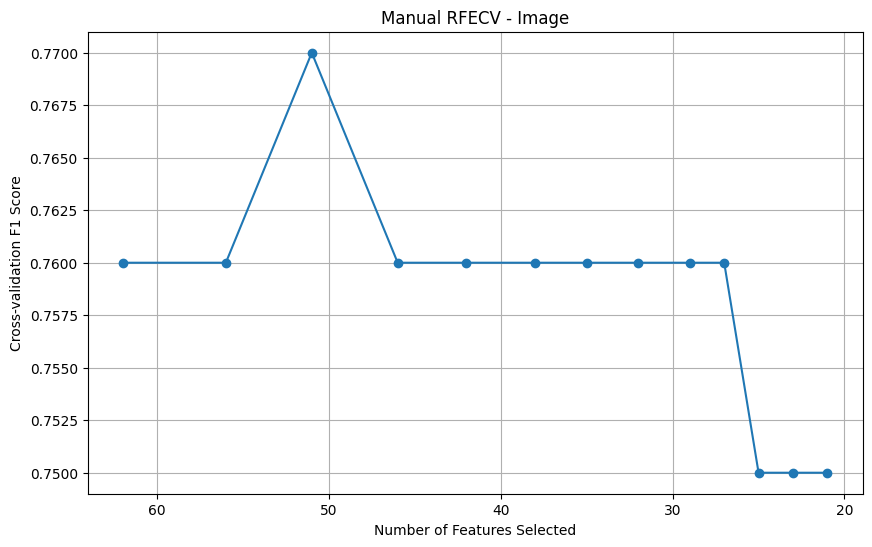


Selecting the final features from the original datasets...

Final datasets for 'Image' stored with selected features.


In [9]:
selected_features_dict = {}

for dataset_name in data_variations.keys():
    
    print(f"\nStarting feature selection for {dataset_name} Dataset")

    if dataset_name=='Clinical':
        print("\nSkipping feature selection for 'Clinical' dataset. Retaining all original features.")
    else:
            # Retrieve data
        data = data_splits[dataset_name]

        X_train_full=data['X_train_full']
        y_train_full=data['y_train_full']
        X_test_full=data['X_test_full']
        y_test=data['y_test']
        
        # Handle Missing Data - Imputation
        print("\nHandling missing data with SimpleImputer...")
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_full)
        X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_full.columns, index=X_train_full.index)

        # Feature Scaling using MinMaxScaler
        print("\nScaling features with MinMaxScaler...")
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)

        # Apply SMOTE to balance the classes in the training data
        print("\nApplying SMOTE to balance the classes...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_full)

        # Convert resampled data back to DataFrame with the original column names and reset indices
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
        y_train_resampled = pd.Series(y_train_resampled)

        print(f"Number of samples after SMOTE: {X_train_resampled.shape[0]}")
        print(f"Class distribution after SMOTE: \n{y_train_resampled.value_counts()}")

        # L1-based Feature Selection
        print("\nPerforming L1-based feature selection...")
        l1_selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000), max_features=100  # Adjust based on expected number of features
        )
        l1_selector.fit(X_train_resampled, y_train_resampled)
        X_train_l1 = l1_selector.transform(X_train_resampled)
        X_train_l1 = pd.DataFrame(X_train_l1, columns=X_train_resampled.columns[l1_selector.get_support()])
        print(f"Number of features after L1-based selection: {X_train_l1.shape[1]}")

        # Verify indices match (SMOTE modifies the indices, so they won't match the original ones)
        print("Resampled data indices are reset after SMOTE.")


        # Ensure that X_train_l1 and y_train_resampled have matching indices
        X_train_l1 = X_train_l1.reset_index(drop=True)
        y_train_resampled = pd.Series(y_train_resampled).reset_index(drop=True)

        # Verify that indices match
        assert X_train_l1.index.equals(y_train_resampled.index), "Indices of X_train_l1 and y_train_resampled do not match."

        # Mann-Whitney U Test Feature Selection with Parallelization
        print("\nPerforming Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...")
        mannwhitney_selector = MannWhitneyUTestFeatureSelector(alpha=0.05, bonferroni=True, n_jobs=-1)
        mannwhitney_selector.fit(X_train_l1, y_train_resampled)
        X_train_mwu = mannwhitney_selector.transform(X_train_l1)
        print(f"Number of features after Mann-Whitney U Test: {X_train_mwu.shape[1]}")


        # Manually perform RFECV using a Random Forest Classifier
        rf_estimator = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=7)

        # Use StratifiedKFold for cross-validation
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform manual RFECV
        best_features, rfecv_history = manual_rfecv(
            X_train_mwu, y_train_resampled, rf_estimator, cv_strategy,
            scoring='f1', min_features_to_select=5, step=0.1,  early_stopping_rounds=10
        )

        # Display best features and history
        print(f"Best Features: {best_features}")
        print(rfecv_history)

        # Plot the number of features vs. cross-validation score
        plt.figure(figsize=(10, 6))
        plt.plot(rfecv_history['n_features'], rfecv_history['cv_score'], marker='o')
        plt.xlabel("Number of Features Selected")
        plt.ylabel("Cross-validation F1 Score")
        plt.title(f"Manual RFECV - {dataset_name}")
        plt.gca().invert_xaxis()  # Optional: Invert x-axis to show decreasing number of features
        plt.grid(True)
        plt.show()

        # Store the selected features
        selected_features = best_features
        selected_features_dict[dataset_name] = selected_features

        # Select the final features from the original datasets
        print("\nSelecting the final features from the original datasets...")

        # Ensure that all selected features exist in the original datasets
        missing_in_train = set(selected_features) - set(X_train_full.columns)
        missing_in_test = set(selected_features) - set(X_test_full.columns)
        if missing_in_train:
            raise ValueError(f"The following selected features are missing in X_train_full: {missing_in_train}")
        if missing_in_test:
            raise ValueError(f"The following selected features are missing in X_test_full: {missing_in_test}")

        # Subset the original X_train_full and X_test_full to include only the selected features
        X_train_final = X_train_full[selected_features].copy()
        X_test_final = X_test_full[selected_features].copy()

        # Reset indices to ensure consistency
        X_train_final.reset_index(drop=True, inplace=True)
        y_train_full = y_train_full.reset_index(drop=True)
        X_test_final.reset_index(drop=True, inplace=True)
        y_test = y_test.reset_index(drop=True)

        # Verify that the number of features matches
        assert X_train_final.shape[1] == X_test_final.shape[1], \
            "Mismatch in number of features between training and test sets."

        # Verify that the number of features matches
        assert X_train_final.shape[0] == y_train_full.shape[0], \
            "Mismatch in number of rows between training X and Y."

        # Verify that the number of features matches
        assert X_test_final.shape[0] == y_test.shape[0], \
            "Mismatch in number of rows between test X and Y."

        # Store the final datasets with selected features in data_splits
        data_splits[dataset_name] = {
            'X_train_full': X_train_final,
            'X_test_full': X_test_final,
            'y_train_full': y_train_full,
            'y_test': y_test
        }

        print(f"\nFinal datasets for '{dataset_name}' stored with selected features.")


In [10]:
# Define classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000)
}

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [50,100],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'LightGBM': {
        'classifier__n_estimators': [50,100],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 63],
        'classifier__verbose': [-1]
    },
    'Random Forest': {
        'classifier__n_estimators': [50,100],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50,100],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'Logistic Regression': {
        'classifier__C': np.logspace(-4, 4, 10),
        'classifier__penalty': ['l1', 'l2']
    },
    'SVM': {
        'classifier__C': [0.05,0.1],
        'classifier__kernel': ['linear', 'rbf']
    }
}

In [11]:
# Nested Cross-Validation Function without RFECV
def nested_cv_evaluation(dataset_name, X, y, classifiers, param_grids, outer_splits=3, inner_splits=2):
    """
    Performs nested cross-validation with hyperparameter tuning.
    RFECV is not included in the pipeline.
    """
    print(f"\nStarting Nested CV for {dataset_name} dataset...")
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    aggregated_scores = {}
    best_estimators = {}
    nested_scores = {name: [] for name in classifiers.keys()}

    for name, classifier in classifiers.items():
        print(f"\nEvaluating {name} on {dataset_name} dataset...")
        start_time = time.time()
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        best_estimators[name] = []

        for train_idx, test_idx in outer_cv.split(X, y):
            X_train_fold, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_valid = y.iloc[train_idx], y.iloc[test_idx]

            # Define the inner cross-validation
            inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

            # Define the pipeline without RFECV
            pipeline = ImbPipeline(steps=[
                ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier', classifier)
            ])

            # Hyperparameter tuning with RandomizedSearchCV
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grids[name],
                scoring='f1',
                n_iter=5,  # Adjusted for efficiency
                cv=inner_cv,
                random_state=42,
                n_jobs=-1
            )

            # Fit the model on the training fold
            search.fit(X_train_fold, y_train_fold)

            # Get the best estimator
            best_model = search.best_estimator_

            # Evaluate on the validation fold
            y_pred = best_model.predict(X_valid)

            # Compute metrics
            accuracy = accuracy_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred, zero_division=0)
            recall = recall_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)

            # Append scores
            scores['accuracy'].append(accuracy)
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
            nested_scores[name].append(f1)

            # Store the best estimator
            best_estimators[name].append(best_model)

        # Aggregate scores
        aggregated_scores[name] = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}

        elapsed_time = time.time() - start_time
        print(f"{name} - Completed in {elapsed_time:.2f} seconds")

    return aggregated_scores, best_estimators, nested_scores


In [12]:
nested_cv_results = {}  # To store nested CV results
for dataset_name in data_variations.keys():
    print(f"\nStarting Nested Cross-Validation for {dataset_name} Dataset")

    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']

    # Perform nested cross-validation
    aggregated_scores, best_estimators, nested_scores = nested_cv_evaluation(
        dataset_name, X_train_full, y_train_full, classifiers, param_grids
    )

    # Store the results
    nested_cv_results[dataset_name] = {
        'aggregated_scores': aggregated_scores,
        'best_estimators': best_estimators,
        'nested_scores': nested_scores
    }


Starting Nested Cross-Validation for Combined Dataset

Starting Nested CV for Combined dataset...

Evaluating Logistic Regression on Combined dataset...
Logistic Regression - Completed in 0.92 seconds

Evaluating Random Forest on Combined dataset...
Random Forest - Completed in 3.12 seconds

Evaluating Gradient Boosting on Combined dataset...
Gradient Boosting - Completed in 25.31 seconds

Evaluating XGBoost on Combined dataset...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:08:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 3.08 seconds

Evaluating LightGBM on Combined dataset...
LightGBM - Completed in 34.02 seconds

Evaluating SVM on Combined dataset...
SVM - Completed in 19.17 seconds

Starting Nested Cross-Validation for Clinical Dataset

Starting Nested CV for Clinical dataset...

Evaluating Logistic Regression on Clinical dataset...
Logistic Regression - Completed in 0.24 seconds

Evaluating Random Forest on Clinical dataset...
Random Forest - Completed in 1.24 seconds

Evaluating Gradient Boosting on Clinical dataset...
Gradient Boosting - Completed in 1.17 seconds

Evaluating XGBoost on Clinical dataset...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 0.42 seconds

Evaluating LightGBM on Clinical dataset...
LightGBM - Completed in 2.22 seconds

Evaluating SVM on Clinical dataset...
SVM - Completed in 0.23 seconds

Starting Nested Cross-Validation for Image Dataset

Starting Nested CV for Image dataset...

Evaluating Logistic Regression on Image dataset...
Logistic Regression - Completed in 0.40 seconds

Evaluating Random Forest on Image dataset...
Random Forest - Completed in 2.54 seconds

Evaluating Gradient Boosting on Image dataset...
Gradient Boosting - Completed in 11.76 seconds

Evaluating XGBoost on Image dataset...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 2.46 seconds

Evaluating LightGBM on Image dataset...
LightGBM - Completed in 31.54 seconds

Evaluating SVM on Image dataset...
SVM - Completed in 22.12 seconds


In [13]:
def statistical_tests_nested(nested_scores):
    """
    Performs statistical tests between models using the Friedman test.
    """
    print("\nStatistical significance testing using the Friedman test:")
    model_names = list(nested_scores.keys())
    scores_array = np.array([nested_scores[name] for name in model_names])

    # Perform Friedman test
    stat, p = friedmanchisquare(*scores_array)
    print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        print("  Significant differences detected between models.")
        # Perform post-hoc Nemenyi test
        nemenyi_results = sp.posthoc_nemenyi_friedman(scores_array.T)
        nemenyi_results.index = model_names
        nemenyi_results.columns = model_names
        print("\nPost-hoc Nemenyi test results:")
        print(nemenyi_results)
    else:
        print("  No significant differences detected between models.")
def select_best_model(aggregated_scores, metric='f1'):
    """
    Selects the best model based on the specified metric.
    """
    best_model_name = max(aggregated_scores.items(), key=lambda x: x[1][metric][0])[0]
    best_score, best_std = aggregated_scores[best_model_name][metric]
    print(f"\nBest model based on {metric.upper()}: {best_model_name} with {metric.upper()} = {best_score:.4f} ± {best_std:.4f}")
    return best_model_name


In [14]:
best_models_info = {}  # To store best model information
for dataset_name in data_variations.keys():
    print(f"\nSelecting Best Model for {dataset_name} Dataset")

    # Retrieve nested CV results
    results = nested_cv_results[dataset_name]
    aggregated_scores = results['aggregated_scores']
    nested_scores = results['nested_scores']

    # Display aggregated scores
    print(f"\nAggregated Scores for {dataset_name} Dataset:")
    for name, metrics in aggregated_scores.items():
        print(f"\n{name} Performance:")
        for metric, (mean_score, std_score) in metrics.items():
            print(f"  {metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

    # Statistical significance testing
    statistical_tests_nested(nested_scores)

    # Select the best model
    best_model_name = select_best_model(aggregated_scores, metric='f1')

    # Store best model name
    best_models_info[dataset_name] = {
        'best_model_name': best_model_name,
        'best_estimators': results['best_estimators']
    }


Selecting Best Model for Combined Dataset

Aggregated Scores for Combined Dataset:

Logistic Regression Performance:
  Accuracy: 0.8878 ± 0.0032
  Precision: 0.6846 ± 0.0083
  Recall: 0.8824 ± 0.0015
  F1: 0.7710 ± 0.0047

Random Forest Performance:
  Accuracy: 0.9843 ± 0.0007
  Precision: 0.9889 ± 0.0133
  Recall: 0.9374 ± 0.0100
  F1: 0.9624 ± 0.0011

Gradient Boosting Performance:
  Accuracy: 0.9843 ± 0.0028
  Precision: 0.9725 ± 0.0093
  Recall: 0.9536 ± 0.0040
  F1: 0.9630 ± 0.0066

XGBoost Performance:
  Accuracy: 0.9806 ± 0.0055
  Precision: 0.9578 ± 0.0158
  Recall: 0.9515 ± 0.0095
  F1: 0.9546 ± 0.0126

LightGBM Performance:
  Accuracy: 0.9919 ± 0.0020
  Precision: 0.9934 ± 0.0027
  Recall: 0.9687 ± 0.0066
  F1: 0.9809 ± 0.0047

SVM Performance:
  Accuracy: 0.9279 ± 0.0020
  Precision: 0.7645 ± 0.0064
  Recall: 0.9590 ± 0.0015
  F1: 0.8507 ± 0.0034

Statistical significance testing using the Friedman test:
Friedman test statistic: 14.0476, p-value: 0.0153
  Significant differ

In [15]:
def retrain_best_model(best_model_name, best_estimators, X_train, y_train):
    """
    Retrains the best model on the entire training set using the optimal hyperparameters.
    RFECV is not included as feature selection has already been performed.
    """
    print(f"\nRetraining the best model ({best_model_name}) on the entire training set...")

    # Get the hyperparameters from the best estimator in cross-validation
    best_params = best_estimators[best_model_name][0].get_params()

    # Extract the classifier's hyperparameters
    classifier_params = {
        key.replace('classifier__', ''): value
        for key, value in best_params.items()
        if key.startswith('classifier__')
    }

    # Create a fresh instance of the best classifier
    if best_model_name == 'LightGBM':
        classifier = lgb.LGBMClassifier(random_state=42)  # Create a new LGBMClassifier instance
    elif best_model_name == 'Random Forest':
        classifier = RandomForestClassifier(random_state=42)
    elif best_model_name == 'Gradient Boosting':
        classifier = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'Logistic Regression':
        classifier = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    elif best_model_name == 'SVM':
        classifier = SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000)
    elif best_model_name == 'XGBoost':
        classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Set the hyperparameters to the fresh classifier instance
    classifier.set_params(**classifier_params)

    # Define the pipeline with the specified steps
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
        ('scaler', MinMaxScaler()),
        ('classifier', classifier)  # Use the fresh classifier instance
    ])

    # Fit the model on the entire training set
    pipeline.fit(X_train, y_train)

    return pipeline
retrained_models = {}  # To store retrained models

In [16]:
for dataset_name in data_variations.keys():
    print(f"\nRetraining Best Model for {dataset_name} Dataset")

    # Retrieve data and best model info
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    best_model_name = best_models_info[dataset_name]['best_model_name']
    best_estimators = best_models_info[dataset_name]['best_estimators']

    # Retrain the best model
    best_model = retrain_best_model(
        best_model_name, best_estimators, X_train_full, y_train_full
    )

    # Store the retrained model and test data
    retrained_models[dataset_name] = {
        'best_model': best_model,
        'selected_features': X_train_full.columns.tolist(),
        'X_test': data['X_test_full'],
        'y_test': data['y_test']
    }


Retraining Best Model for Combined Dataset

Retraining the best model (LightGBM) on the entire training set...

Retraining Best Model for Clinical Dataset

Retraining the best model (LightGBM) on the entire training set...

Retraining Best Model for Image Dataset

Retraining the best model (Logistic Regression) on the entire training set...


In [17]:
def interpret_model(model, model_name, X_test):
    """
    Interprets the model using SHAP for tree-based models or coefficient analysis for logistic regression.
    """
    if model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
        print("\nPerforming SHAP analysis for model interpretability...")
        try:
            # Create an explainer
            explainer = shap.Explainer(model.named_steps['classifier'], X_test)
            shap_values = explainer(X_test)

            # Plot SHAP summary plot
            shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
    elif model_name == 'Logistic Regression':
        # For linear models
        print("\nAnalyzing coefficients for feature importance...")
        try:
            coefficients = model.named_steps['classifier'].coef_[0]
            feature_names = X_test.columns
            feature_importance = pd.Series(coefficients, index=feature_names)
            top_features = feature_importance.abs().sort_values(ascending=False).head(10)
            print(f"Top 10 Features based on coefficients for {model_name}:")
            print(top_features)

            # Plot top features
            plt.figure(figsize=(8, 6))
            sns.barplot(x=top_features.values, y=top_features.index)
            plt.title(f'Top 10 Features - {model_name}')
            plt.xlabel('Coefficient Magnitude')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Coefficient analysis failed: {e}")
    else:
        print(f"{model_name} does not support SHAP or coefficient analysis for interpretability.")



Evaluating Best Model on Test Set for Combined Dataset

Test Set Performance on Combined Dataset:
Accuracy: 0.9940
Balanced Accuracy: 0.9864
Precision: 0.9989
Sensitivity (Recall): 0.9730
Specificity: 0.9997
F1 Score: 0.9858
ROC AUC Score: 0.9996

Performing SHAP analysis for model interpretability...


 98%|===================| 4247/4330 [00:22<00:00]        

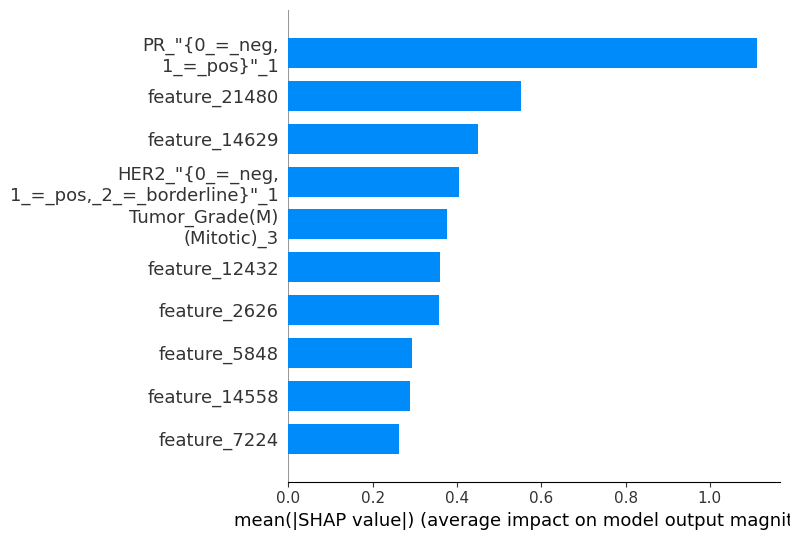


Evaluating Best Model on Test Set for Clinical Dataset

Test Set Performance on Clinical Dataset:
Accuracy: 0.7252
Balanced Accuracy: 0.6109
Precision: 0.4000
Sensitivity (Recall): 0.4000
Specificity: 0.8218
F1 Score: 0.4000
ROC AUC Score: 0.6868

Performing SHAP analysis for model interpretability...


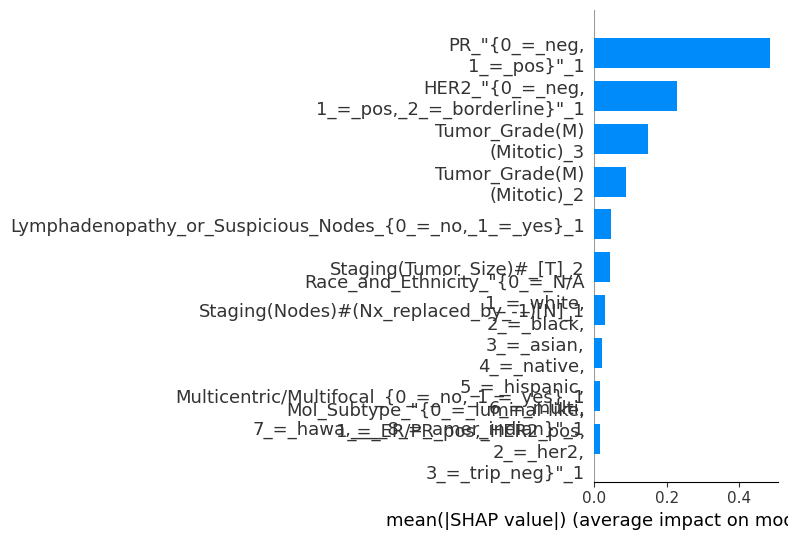


Evaluating Best Model on Test Set for Image Dataset

Test Set Performance on Image Dataset:
Accuracy: 0.5383
Balanced Accuracy: 0.5067
Precision: 0.2190
Sensitivity (Recall): 0.4514
Specificity: 0.5620
F1 Score: 0.2949
ROC AUC Score: 0.5109

Analyzing coefficients for feature importance...
Top 10 Features based on coefficients for Logistic Regression:
feature_20664    3.557847
feature_14713    3.429717
feature_14876    3.010263
feature_7428     2.751422
feature_9237     2.574044
feature_15556    2.527433
feature_3601     1.924282
feature_7455     1.800643
feature_11606    1.603999
feature_1343     1.572795
dtype: float64


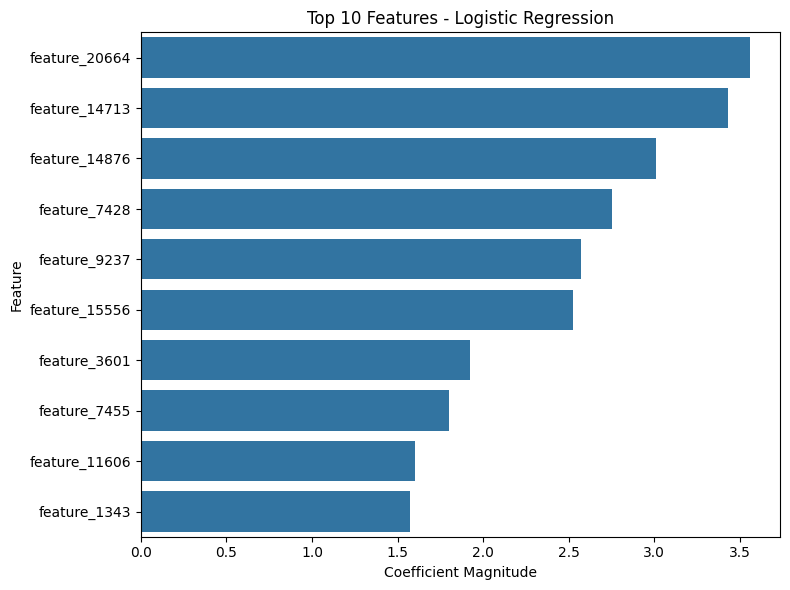

In [18]:
for dataset_name in data_variations.keys():
    print(f"\nEvaluating Best Model on Test Set for {dataset_name} Dataset")

    # Retrieve retrained model and test data
    model_info = retrained_models[dataset_name]
    best_model = model_info['best_model']
    X_test = model_info['X_test']
    y_test = model_info['y_test']

    # Evaluate the model on the test set
    y_pred_test = best_model.predict(X_test)
    y_proba_test = best_model.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Print evaluation results
    print(f"\nTest Set Performance on {dataset_name} Dataset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {(conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])):.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Model Interpretability
    interpret_model(best_model, best_models_info[dataset_name]['best_model_name'], X_test)
